In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed
from numba import jit

# Define the fitness function for feature selection using RandomForestClassifier
def fitness_function(solution, data, target):
    selected_features = data[:, solution == 1]
    if selected_features.shape[1] == 0:  # No features selected
        return 0
    clf = RandomForestClassifier(random_state=42)
    scores = cross_val_score(clf, selected_features, target, cv=5)
    return scores.mean()

# Initialize the population for GA
def initialize_population(pop_size, num_features):
    return np.random.randint(2, size=(pop_size, num_features))

# Selection: Tournament selection
def selection(population, fitness_values, k=3):
    selected_indices = np.random.choice(len(population), k)
    best_index = selected_indices[np.argmax(fitness_values[selected_indices])]
    return population[best_index]

# Blended Crossover
def blended_crossover(parent1, parent2, alpha=0.5):
    child1 = alpha * parent1 + (1 - alpha) * parent2
    child2 = alpha * parent2 + (1 - alpha) * parent1
    return np.round(child1).astype(int), np.round(child2).astype(int)

# Mutation: Bit flip mutation
def mutation(chromosome, mutation_rate):
    for i in range(len(chromosome)):
        if np.random.rand() < mutation_rate:
            chromosome[i] = 1 - chromosome[i]
    return chromosome

# PSO parameters and update functions with dynamic adjustment
@jit(nopython=True)
def update_velocity(vel, pos, pbest_pos, gbest_pos, w, c1, c2):
    r1, r2 = np.random.rand(), np.random.rand()
    new_vel = (w * vel + c1 * r1 * (pbest_pos - pos) +
               c2 * r2 * (gbest_pos - pos))
    return new_vel

@jit(nopython=True)
def update_position(pos, vel):
    sigmoid = 1 / (1 + np.exp(-vel))
    new_pos = np.where(sigmoid >= np.random.rand(len(sigmoid)), 1, 0)
    return new_pos

# Hybrid GA-PSO algorithm for feature selection with dynamic PSO parameters
def hybrid_ga_pso(data, target, pop_size=100, num_features=31, max_ga_generations=200,
                  max_pso_iterations=100, ga_convergence_threshold=0.0001,
                  pso_convergence_threshold=0.0001, w_max=0.9, w_min=0.4, c1_init=2.5, c2_init=0.5,
                  mutation_rate=0.02, n_jobs=-1):

    # Initialize populations
    population = initialize_population(pop_size, num_features)
    velocities = np.zeros((pop_size, num_features))

    # Initialize personal best and global best for GA
    pbest_pos = np.copy(population)
    pbest_val = Parallel(n_jobs=n_jobs)(delayed(fitness_function)(ind, data, target) for ind in population)
    pbest_val = np.array(pbest_val)
    gbest_pos = population[np.argmax(pbest_val)]
    gbest_val = np.max(pbest_val)

    ga_convergence = []
    pso_convergence = []

    # GA Phase
    for generation in range(max_ga_generations):
        # GA operations
        new_population = np.zeros_like(population)
        new_velocities = np.zeros_like(velocities)
        for i in range(pop_size - 1):  # Iterate up to pop_size - 1
            parent1 = selection(population, pbest_val)
            parent2 = selection(population, pbest_val)
            child1, child2 = blended_crossover(parent1, parent2)
            child1 = mutation(child1, mutation_rate)
            child2 = mutation(child2, mutation_rate)
            new_population[i] = child1
            new_population[i+1] = child2
            new_velocities[i] = update_velocity(velocities[i], population[i], pbest_pos[i], gbest_pos, w_max, c1_init, c2_init)
            new_velocities[i+1] = update_velocity(velocities[i+1], population[i+1], pbest_pos[i+1], gbest_pos, w_max, c1_init, c2_init)
        population = new_population
        velocities = new_velocities

        # Update personal best
        new_fitness = Parallel(n_jobs=n_jobs)(delayed(fitness_function)(ind, data, target) for ind in population)
        new_fitness = np.array(new_fitness)
        pbest_pos[new_fitness > pbest_val] = population[new_fitness > pbest_val]
        pbest_val[new_fitness > pbest_val] = new_fitness[new_fitness > pbest_val]

        # Update global best
        gbest_index = np.argmax(pbest_val)
        if pbest_val[gbest_index] > gbest_val:
            gbest_pos = np.copy(pbest_pos[gbest_index])
            gbest_val = pbest_val[gbest_index]

        # Check convergence
        ga_convergence.append(gbest_val)
        if len(ga_convergence) > 1 and np.abs(ga_convergence[-1] - ga_convergence[-2]) < ga_convergence_threshold:
            break

    # PSO Phase
    for iteration in range(max_pso_iterations):
        # Dynamically adjust PSO parameters
        w = w_max - (w_max - w_min) * (iteration / max_pso_iterations)
        c1 = c1_init - (c1_init - 1.5) * (iteration / max_pso_iterations)
        c2 = c2_init + (2.5 - c2_init) * (iteration / max_pso_iterations)

        for i in range(pop_size):
            velocities[i] = update_velocity(velocities[i], population[i], pbest_pos[i], gbest_pos, w, c1, c2)
            population[i] = update_position(population[i], velocities[i])

        # Update personal best
        new_fitness = Parallel(n_jobs=n_jobs)(delayed(fitness_function)(ind, data, target) for ind in population)
        new_fitness = np.array(new_fitness)
        pbest_pos[new_fitness > pbest_val] = population[new_fitness > pbest_val]
        pbest_val[new_fitness > pbest_val] = new_fitness[new_fitness > pbest_val]

        # Update global best
        gbest_index = np.argmax(pbest_val)
        if pbest_val[gbest_index] > gbest_val:
            gbest_pos = np.copy(pbest_pos[gbest_index])
            gbest_val = pbest_val[gbest_index]

        # Check convergence
        pso_convergence.append(gbest_val)
        if len(pso_convergence) > 1 and np.abs(pso_convergence[-1] - pso_convergence[-2]) < pso_convergence_threshold:
            break

    return gbest_pos, gbest_val

if __name__ == "__main__":
    # Read data from CSV file
    df = pd.read_csv('PhishingDataset.csv')

    # Assuming the last column is the target variable
    data = df.iloc[:, :-1].values
    target = df.iloc[:, -1].values
    feature_names = df.columns[:-1].tolist()

    # Run the hybrid GA-PSO algorithm
    best_solution, best_fitness = hybrid_ga_pso(data, target, num_features=data.shape[1])

    # Print the final optimized feature selection
    selected_features_indices = np.where(best_solution == 1)[0]
    selected_features_names = [feature_names[i] for i in selected_features_indices]

    print("Selected Feature Indices:", selected_features_indices)
    print("Selected Feature Names:", selected_features_names)
    print("Best Fitness (Accuracy):", best_fitness)


Selected Feature Indices: [ 1  2  4  5  6  7  8 12 13 14 16 17 18 19 21 22 23 24 25 26 27 28 29]
Selected Feature Names: ['URL_Length', 'Shortining_Service', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report']
Best Fitness (Accuracy): 0.9640886476707372


Feature: URL_Length, Importance: 0.010953518408592362
Feature: Shortining_Service, Importance: 0.0056028739980771725
Feature: double_slash_redirecting, Importance: 0.005227064044118137
Feature: Prefix_Suffix, Importance: 0.04256645670849211
Feature: having_Sub_Domain, Importance: 0.06696742286011098
Feature: SSLfinal_State, Importance: 0.35534978555138924
Feature: Domain_registeration_length, Importance: 0.016734653641361143
Feature: Request_URL, Importance: 0.01871438909095326
Feature: URL_of_Anchor, Importance: 0.23959228636090266
Feature: Links_in_tags, Importance: 0.04461385747160089
Feature: Submitting_to_email, Importance: 0.007392499853048285
Feature: Abnormal_URL, Importance: 0.005494311807175074
Feature: Redirect, Importance: 0.006237231219047333
Feature: on_mouseover, Importance: 0.004643036081972484
Feature: popUpWidnow, Importance: 0.006801806026456522
Feature: Iframe, Importance: 0.0031180907680665258
Feature: age_of_domain, Importance: 0.016836468366615048
Feature: DNSRec

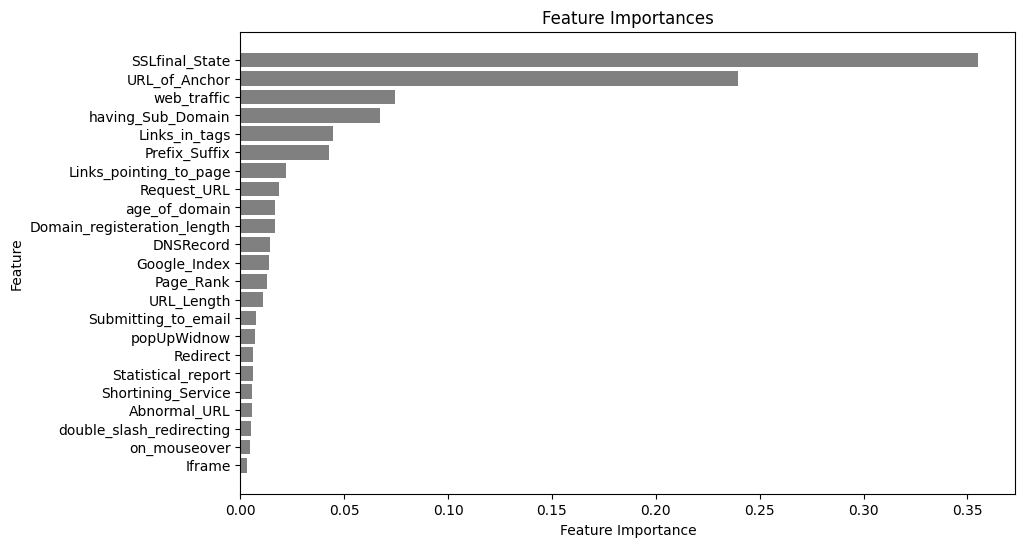

In [ ]:
# Train RandomForestClassifier on selected features to get feature importances
selected_data = data[:, best_solution == 1]
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(selected_data, target)
feature_importances = clf.feature_importances_

# Print feature importances
for feature, importance in zip(selected_features_names, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

# Sort feature importances in increasing order
sorted_indices = np.argsort(feature_importances)
sorted_feature_names = [selected_features_names[i] for i in sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

# Plot feature importances in increasing order with grey color
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances, color='grey')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()